# Mumbai Travel time and accessibility analysis

We have data for 3,020 unique ids. **note: the original dataset had 3,135 rows but 115 of them did not have a PIN code for the work destination.** The dataset is named "2019 08 14 Jobs Data from Module 9". 

In addition the first two columns were combined in order to create unique ids. Each id represents a respondent in the survey who commutes to work. 

We are primarily looking to do two kinds of analysis. For both types of analysis described below, we will calculate travel times according to three modes of transit:
1. OSM road network driving with standard road classes
2. Rail network (known) with walking to the rail station
3. A combined rail and road network with the option of taking both forms of transportation
 
First, identify the households which have individual work places identified by PIN code (There are 107 PIN codes), and calculate their travel time. The second analysis is for every geocoded household, calculate job accessibilitiy indices.

1. Distance from residence to work place; estimated travel time (analysis 1)
          a. Calculate distance from house to workplace using (i) road network; (ii) rail network 
          b. Calculate travel time via road network and rail network
          c. Calculate travel time via walking
          d. Calculate Euclidean distance from house to workplace for each worker 

**note that not all the households could be matched to PIN codes, for example, there is no 400000 PIN code in the dataset.**

2. Index of employment accessibility (analysis 2)
          a. In addition to the information used in analysis 1, we have information on employment, by gender and industry for 99 Sections of Mumbai.
          b. We would like to combine this information with household location information from the survey to calculate an index of employment accessibility (separate index for men and women) for each household in the sample. The index would measure number of jobs accessible based on a weighted gravity model. 
          c. We are also calculating the number of jobs accessible per household based on three travel windows (30 min, 60 min, and 90 min).


### The parameters are used in our model:

- metroSpeed = 35 #kph
- railSpeed = 40 #kph
- station_wait = 30 #seconds
- walk_speed = 5 #kph

## import libraries

In [689]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [690]:
# Get reference to OSMNX_POIs
sys.path.append(r'../..')
from Market_Access import OSMNX_POIs

In [691]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [692]:
# Define input data and create a number of output datasets if they do not yet exist
inputFolder = r'./input_folder'

inputRailways = os.path.join(inputFolder, "Mumbai_Railway_MANUAL_43N.shp")
inputRailstops = os.path.join(inputFolder, "Mumbai_Railway_stations_MANUAL.shp")

sections = gpd.read_file(os.path.join(inputFolder, "greater_mumbai_merged.shp"))
pin_codes = gpd.read_file(os.path.join(inputFolder, "mumbai_pin_codes.shp"))

In [693]:
# this data is not public
inputFolder2 = r'../../../mumbai_input_folder2'

inHouseholds = os.path.join(inputFolder2, "2019_08_14_households_and_destinations_reformatted3.csv")
employment_by_section_path = os.path.join(inputFolder2, "employment_by_section.csv")
inJD_by_section = pd.read_csv(employment_by_section_path)

In [694]:
# not using employment by section data for for analysis 1
# Read in the Section admin boundaries and extract the centroids
inJ_by_section = pd.merge(sections, inJD_by_section, left_on="WARD_NO", right_on="section")
inJ_cen_by_section = inJ_by_section.copy()
inJ_cen_by_section['geometry'] = inJ_cen_by_section.centroid

# Read in the PIN admin boundaries and extract the centroids
pin_codes_w_centroids = pin_codes.copy()
pin_codes_w_centroids['geometry'] = pin_codes_w_centroids.centroid

outputFolder = r'../../../mumbai_output_folder'

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

outGraph = os.path.join(outputFolder, "OSM_Roads.pickle")
outRailGraph = os.path.join(outputFolder, "OSM_Rail.pickle")

### calculate speeds using original speed dictionary

In [695]:
# original speed dict
speed_dict = {
               'residential': 20,  # kmph
               'primary': 40, # kmph
               'primary_link':35,
               'motorway':50,
               'motorway_link': 45,
               'trunk': 40,
               'trunk_link':35,
               'secondary': 30,
               'secondary_link':25,
               'tertiary':30,
               'tertiary_link': 25,
               'unclassified':20
               }
# the default speed if no match is 20kph

In [696]:
# This is the section where we can adjust the road speeds
if not os.path.exists(outGraph):
    extent = box(*inJ_cen_by_section.total_bounds)
    G = ox.graph_from_polygon(extent, network_type = 'drive_service')
    # This is how time is calculated from the OSMNX length attribute
    G = gn.convert_network_to_time(G, 'length', speed_dict = speed_dict)
    # save the largerst subgraph
    list_of_Gs = list((nx.strongly_connected_component_subgraphs(G)))
    sz = 0
    largest_G = list_of_Gs[0]
    for g in list_of_Gs:
        curSize = g.size()
        if curSize > sz:
            largest_G = g
            sz = curSize
    G = largest_G
    print('print G')
    print(sz)
    nx.write_gpickle(G, outGraph)
else:
    G = nx.read_gpickle(outGraph)    
    G = gn.convert_network_to_time(G, 'length', speed_dict = speed_dict)

print G
66805


### This block saves the roads as a shapefile for inspection purposes

In [697]:
# Highway features are reclassified to 4 OSMLR classes for simplification and standardization
# https://mapzen.com/blog/osmlr-2nd-technical-preview/
OSMLR_Classes = {
"motorway":"OSMLR level 1",
"motorway_link":"OSMLR level 1",
"trunk":"OSMLR level 1",
"trunk_link":"OSMLR level 1",
"primary":"OSMLR level 1",
"primary_link":"OSMLR level 1",

"secondary":"OSMLR level 2",
"secondary_link":"OSMLR level 2",
"tertiary":"OSMLR level 2",
"tertiary_link":"OSMLR level 2",

"unclassified":"OSMLR level 3",
"unclassified_link": "OSMLR level 3",
"residential": "OSMLR level 3",
"residential_link": "OSMLR level 3",

"track": "OSMLR level 4",
"service": "OSMLR level 4"
}

In [698]:
roads = gn.edge_gdf_from_graph(G)
roads['highway'] = roads.highway.astype(str)
roads['OSMLR'] = roads.highway.map(OSMLR_Classes)
roads['oneway'] = roads.oneway.astype(int)
# geopandas cannot save dataframe to file if fields contain lists. 
# There have been instances where fields such as 'osmid' and 'highway' contain a list.
# Therefore reduce the number of fields
roads = roads[['OSMLR','oneway','length','time','mode','geometry']]
roads.to_file(outputFolder + '/OSM_Roads')

In [699]:
# inspect the road nodes
from shapely.geometry import Point
g_point_gdf = gn.node_gdf_from_graph(G,crs = {'init' :'epsg:4326'})
#g_point_gdf = g_point_gdf.drop(columns=['geom'])
g_point_gdf.to_file(driver = 'ESRI Shapefile', filename = outputFolder + '/OSM_Roads_nodes.shp')

### Generate speed dictionaries based on average peak, off-peak, and average speeds

In [700]:
# find the average speed of the road graph
avg_graph_speed = gn.find_graph_avg_speed(G, 'length', 'time')
print(avg_graph_speed)

22.075206686567725


In [701]:
# 15kph peak
# 16.5kph avg speed
# 20kph off-peak
peak_ratio = 15/avg_graph_speed
avg_speed_ratio = 16.5/avg_graph_speed
off_peak_ratio = 20/avg_graph_speed

In [702]:
# find all classes of highways
highway_classes = gn.find_hwy_distances_by_class(G)
highway_classes

{'residential': 2750058.3460000083,
 'primary': 280381.7460000001,
 'tertiary': 705405.3600000007,
 'unclassified': 1944979.2219999959,
 'motorway': 50689.783999999985,
 'secondary': 529089.1960000002,
 'trunk': 167778.20200000002,
 'living_street': 224322.87500000055,
 'service': 664795.6699999991,
 'trunk_link': 34657.96100000001,
 'primary_link': 16368.254999999992,
 'secondary_link': 2853.644000000001,
 'motorway_link': 9351.706,
 'tertiary_link': 3194.3910000000014,
 'road': 1387.3359999999998}

In [703]:
speed_peak_dict = {}
speed_avg_dict = {}
speed_off_peak_dict = {}

In [704]:
for key in speed_dict:
    speed_peak_dict[key] = speed_dict[key] * peak_ratio
    speed_avg_dict[key] = speed_dict[key] * avg_speed_ratio
    speed_off_peak_dict[key] = speed_dict[key] * off_peak_ratio 

In [705]:
# add living_street, service, and road
speed_peak_dict_default_speed = 20 * peak_ratio
speed_peak_dict['living_street']=speed_peak_dict_default_speed
speed_peak_dict['service']=speed_peak_dict_default_speed
speed_peak_dict['road']=speed_peak_dict_default_speed

speed_avg_dict_default_speed = 20 * avg_speed_ratio
speed_avg_dict['living_street']=speed_avg_dict_default_speed
speed_avg_dict['service']=speed_avg_dict_default_speed
speed_avg_dict['road']=speed_avg_dict_default_speed
  
speed_off_peak_dict_default_speed = 20 * off_peak_ratio
speed_off_peak_dict['living_street']=speed_off_peak_dict_default_speed
speed_off_peak_dict['service']=speed_off_peak_dict_default_speed
speed_off_peak_dict['road']=speed_off_peak_dict_default_speed

In [706]:
speed_peak_dict

{'residential': 13.589906733808448,
 'primary': 27.179813467616896,
 'primary_link': 23.782336784164784,
 'motorway': 33.97476683452112,
 'motorway_link': 30.577290151069008,
 'trunk': 27.179813467616896,
 'trunk_link': 23.782336784164784,
 'secondary': 20.38486010071267,
 'secondary_link': 16.98738341726056,
 'tertiary': 20.38486010071267,
 'tertiary_link': 16.98738341726056,
 'unclassified': 13.589906733808448,
 'living_street': 13.589906733808448,
 'service': 13.589906733808448,
 'road': 13.589906733808448}

In [707]:
speed_avg_dict

{'residential': 14.948897407189293,
 'primary': 29.897794814378585,
 'primary_link': 26.160570462581262,
 'motorway': 37.37224351797323,
 'motorway_link': 33.63501916617591,
 'trunk': 29.897794814378585,
 'trunk_link': 26.160570462581262,
 'secondary': 22.42334611078394,
 'secondary_link': 18.686121758986616,
 'tertiary': 22.42334611078394,
 'tertiary_link': 18.686121758986616,
 'unclassified': 14.948897407189293,
 'living_street': 14.948897407189293,
 'service': 14.948897407189293,
 'road': 14.948897407189293}

In [708]:
speed_off_peak_dict

{'residential': 18.11987564507793,
 'primary': 36.23975129015586,
 'primary_link': 31.709782378886377,
 'motorway': 45.29968911269482,
 'motorway_link': 40.76972020142534,
 'trunk': 36.23975129015586,
 'trunk_link': 31.709782378886377,
 'secondary': 27.179813467616896,
 'secondary_link': 22.64984455634741,
 'tertiary': 27.179813467616896,
 'tertiary_link': 22.64984455634741,
 'unclassified': 18.11987564507793,
 'living_street': 18.11987564507793,
 'service': 18.11987564507793,
 'road': 18.11987564507793}

## Create a road graph for each travel time category

In [709]:
speed_dict_list = [[speed_peak_dict,"peak_speed"],[speed_avg_dict,"avg_speed"],[speed_off_peak_dict,"off_peak_speed"]]

road_graph = {}
for i in speed_dict_list:
    # This is the section where we can adjust the road speeds
    G = nx.read_gpickle(outGraph)    
    road_graph[i[1]] = gn.convert_network_to_time(G, 'length', speed_dict = i[0])
    nx.write_gpickle(road_graph[i[1]], os.path.join(outputFolder, "OSM_%s_Roads.pickle" % (i[1])))
    # double-check the road graph G
    # gn.example_edge(G, 3)
    # find the average speed of the road graph
    print(gn.find_graph_avg_speed(G, 'length', 'time'))

22.075206686567725
22.075206686567725
22.075206686567725


## Generate the rail network part I
#### This takes in the input railways and converts it to a geodataframe of points. Then the input station points are snapped to these points and the geometries of the stations get changed to match the geometry of the point it was snapped to

In [710]:
if not os.path.exists(outRailGraph):
    #Read in the input railways check for problems, and project
    inR = gpd.read_file(inputRailways)
    inR = inR[[r is not None for r in inR.geometry]]
    if inR.crs == {'init':'epsg:4326'}:
        #inR = misc.project_UTM(inR)
        print('skip')
    inR = inR.to_crs({'init': 'epsg:32643'})

    # line below not needed because length will be generated at a later step
    # inR['length'] = inR['geometry'].apply(lambda x: x.length)

    #Read in the railway stations and project
    inS = gpd.read_file(inputRailstops)
    inS = inS[inS['railway'] == "station"]

    inS_proj = inS.to_crs({'init': 'epsg:32643'})
    print('check projection inS')
    print(inS_proj.crs)

    print('check projection inR')
    print(inR.crs)

    #Generate the Rail network from the rail shapefile
    allRailLines = unary_union(inR['geometry'])

    # deconstructing the rail network into a geodataframe of points
    bag_of_points,ids = [],[]
    id_ = 0
    for r in allRailLines.geoms:
        for q in r.coords:
            bag_of_points.append(q)
            ids.append(id_)
            id_+=1

    df_temp = pd.DataFrame(({'ids':ids,'geometry':bag_of_points}))
    df_temp['geometry'] = df_temp['geometry'].apply(Point)
    gdf_temp = gpd.GeoDataFrame(df_temp, crs = inR.crs, geometry = 'geometry')

    # for testing temporarily export rail bag of points
    #gdf_temp.to_file(driver = 'ESRI Shapefile', filename = 'pre_railine_points3.shp' )

    # for testing temporarily export rail stations
    #inS_proj.to_file(driver = 'ESRI Shapefile', filename = 'pre_station_points3.shp' )

    # the source_crs should be the same proj as both the input graph and input geodataframe of points
    # the rail points need to be snapped to the rail because later the snapped points will be used to split the rail
    inS_proj_snapped = gn.pandana_snap_points(inS_proj, 
                                              gdf_temp, 
                                              source_crs = 'epsg:32643', 
                                              target_crs = 'epsg:32643',
                                              add_dist_to_node_col = True)
    inS_proj_snapped_temp = inS_proj_snapped.drop_duplicates('NN')

    # I think that when the rail stations got snapped to the nearest node in the dataframe it is keeping the original geometry
    # but it is adding the NN id and the NN_distance

    # Therefore join to the Rail gdf to add the geometries of the nodes snapped to
    inS_proj_snapped_temp = inS_proj_snapped_temp.rename(columns={"geometry": "original_geometry"})
    inS_proj_snapped_temp_joined = inS_proj_snapped_temp.set_index('NN').join(gdf_temp.set_index('ids'))
    inS_proj_snapped_temp_joined = inS_proj_snapped_temp_joined.reset_index()

    # note when I had both original_geometry and geometry columns there was an error in outputting a shapefile
    # it must have been confused with two geometry columns, therefore I am dropping the 'original_geometry' column
    inS_proj_snapped_temp_joined_slim = inS_proj_snapped_temp_joined.drop(columns="original_geometry")
    inS_proj_snapped_temp_joined_slim

    #inS_proj_snapped_temp.keys()

    inS_proj_snapped_temp_joined_geo = gpd.GeoDataFrame(inS_proj_snapped_temp_joined_slim, crs = inS_proj.crs, geometry = 'geometry')
    # preview the snapped rail stations
    inS_proj_snapped_temp_joined_geo.to_file(driver = 'ESRI Shapefile', filename = outputFolder + '/snapped_rail_stations3.shp')

check projection inS
{'init': 'epsg:32643'}
check projection inR
{'init': 'epsg:32643'}


../../GOSTNets/GOSTNets/GOSTnet.py:1770: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(target_gdf[['x','y']].as_matrix())
../../GOSTNets/GOSTNets/GOSTnet.py:1772: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(source_gdf[['x','y']].as_matrix())


In [711]:
inS_proj_snapped_temp_joined_geo[:2]

,NN,full_id,osm_id,osm_type,name,network,railway,ref,wikidata,wikipedia,...,short_name,constructi,disused,proposed,alt_name_h,name_pa,highway,traffic_si,NN_dist,geometry
0,291,n213030669,213030669,node,Dahisar,None,station,DIC,Q5208848,en:Dahisar railway station,...,None,None,None,None,None,None,None,None,27.096695,POINT (275001.078 2129854.902)
1,627,n213030714,213030714,node,Santacruz,IR,station,STC,Q7420001,en:Santacruz railway station,...,None,None,None,None,None,None,None,None,37.092462,POINT (272926.070 2111281.305)


## Generate the rail network Part II
#### The allRailLines are the result of a unary union on the railway lines. Therefore they are only multiLine geometries without any attribution. The snapped railway stations also undergo a unary union and are now multiPoint. allRailLines gets split by the snapped railway stations and all the parts are put back together creating a MultiDiGraph.

In [712]:
if not os.path.exists(outRailGraph):
    bag_of_relevant_points = unary_union(inS_proj_snapped_temp_joined_geo.geometry)

    # a shapely.ops function
    split_geoms = split(allRailLines, bag_of_relevant_points)

    print('print count of split geometries')
    print(len(split_geoms))

    geom_bag = []

    for geom in split_geoms:
        g = geom.coords[0]
        h = geom.coords[-1]
        geom_bag.append(str(g))
        geom_bag.append(str(h))

    ref = pd.DataFrame({'node_ids':range(0, len(geom_bag)),'geoms':geom_bag})
    ref = ref.drop_duplicates('geoms')
    ref = ref.set_index('geoms')

    nodes = []
    edges = []

    for geom in split_geoms:
        u_data,v_data,edge_data = {},{},{}

        # start node
        # it is getting a reference to that node's coords
        u = ref['node_ids'].loc[str(geom.coords[0])]
        u_data['x'] = geom.coords[0][0]
        u_data['y'] = geom.coords[0][1]
        u_data['geom'] = Point(geom.coords[0])
        #u_data['string'] = str(geom.coords[0])

        # end node
        v = ref['node_ids'].loc[str(geom.coords[-1])]
        v_data['x'] = geom.coords[-1][0]
        v_data['y'] = geom.coords[-1][1]
        v_data['geom'] = Point(geom.coords[-1])
        #v_data['string'] = str(geom.coords[-1])

        # edge
        edge_data['geom'] = geom
        edge_data['length'] = geom.length
        #edge_data['rail_type'] = geom.rail_type

        nodes.append((u,u_data))
        nodes.append((v,v_data))
        edges.append((u,v,edge_data))
        edges.append((v,u,edge_data))

        id_ += 2

    G_rail = nx.MultiDiGraph()
    G_rail.add_nodes_from(nodes)
    G_rail.add_edges_from(edges)

print count of split geometries
91


#### you can see below that the edges only have the geometry and the length attributes

In [713]:
gn.example_edge(G_rail, 2)

(0, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebef0>, 'length': 1388.5881250271614})
(1, 0, {'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebef0>, 'length': 1388.5881250271614})


In [714]:
gn.example_node(G_rail, 2)

(0, {'x': 272122.66290875676, 'y': 2095693.7796779373, 'geom': <shapely.geometry.point.Point object at 0x7f73d2c54160>})
(1, {'x': 272366.8491270583, 'y': 2097048.8173944994, 'geom': <shapely.geometry.point.Point object at 0x7f73e7aeb908>})


#### you can see below that there is an additional attribute 'rail_type' that we would like to add to the edges

In [715]:
inR[:5]

,id,length,rail_type,geometry
0,1.0,49224.263829,rail,"LINESTRING (274371.400 2137271.121, 274392.826..."
1,2.0,30343.365621,rail,"LINESTRING (287196.192 2122663.190, 286933.399..."
2,3.0,15313.909123,rail,"LINESTRING (282341.652 2107437.900, 282277.064..."
3,4.0,13809.747059,rail,"LINESTRING (276859.800 2109421.985, 276698.102..."
4,5.0,28081.137061,rail,"LINESTRING (276859.800 2109421.985, 276367.012..."


### Find all edges that intersect the input railways and where they do add the attributes to the edges

In [716]:
if not os.path.exists(outRailGraph):
    # Remember that this is a MultiDiGraph so there are two directed edges between each pair of nodes. 
    graph_edge_count = 0
    graph_edge_intersects = 0
    graph_edge_no_intersects = 0

    # loop through each edge in the graph
    for edge in G_rail.edges(data=True):
        graph_edge_count += 1
        # loop through each railway in the input railway geodataframe
        for row in inR.itertuples(index=False):
            # if there is an intersection
            if edge[2]['geom'].intersects(row.geometry):
                # print("an intersection has occurred")
                graph_edge_intersects += 1
                # for the edge add all the attributes that are not length or geometry
                row_dict = row._asdict()
                for name,value in row_dict.items():
                    if not (name=='geometry' or name=='length'):
                        #print(name)
                        # This updates the edge and adds a new attribute key and value
                        #G_rail[edge[0]][edge[1]][0].update(name=value)
                        G_rail[edge[0]][edge[1]][0][name]=value
            else:
                graph_edge_no_intersects += 1
    nx.write_gpickle(G_rail, outRailGraph)
else:
    G_rail = nx.read_gpickle(outRailGraph) 
    
print(graph_edge_count)
print(graph_edge_intersects)
print(graph_edge_no_intersects)

182
274
2274


In [717]:
# you can see that the attributes have been added to the graph
for edge in G_rail.edges(data=True):
    print(edge[2])

{'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebef0>, 'length': 1388.5881250271614, 'id': 6.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebef0>, 'length': 1388.5881250271614, 'id': 6.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aeb978>, 'length': 813.9703934797581, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aeb978>, 'length': 813.9703934797581, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f73d33e3e10>, 'length': 939.3411041555928, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f73dc784390>, 'length': 2016.7291243058262, 'id': 11.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebf28>, 'length': 1083.3242072371213, 'id': 8.0, 'rail_type': 'rail'}
{'geom': <shapely.geometry.linest

## visualize network

/home/vagrant/.conda/envs/GOST_PublicGoods5/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/vagrant/.conda/envs/GOST_PublicGoods5/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


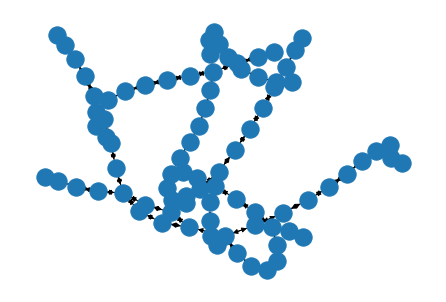

In [718]:
nx.draw(G_rail)

### Tests for the validity of the rail graph

In [719]:
# this is a test to export a shapefile for testing
list_of_Gs = list((nx.strongly_connected_component_subgraphs(G_rail)))
sz = 0
largest_G = list_of_Gs[0]
count = 0
for g in list_of_Gs:
    curSize = g.size()
    #print(curSize)
    if curSize > sz:
        largest_G = g
        sz = curSize 
    g_gdf = gn.edge_gdf_from_graph(g,crs = {'init' :'epsg:32643'})
    # for some reason has both a geom and geometry column
    g_gdf = g_gdf.drop(columns=['geom'])
    # print(g_gdf)
    g_gdf.to_file(driver = 'ESRI Shapefile', filename = outputFolder + '/g_rail_gdf_test_%d.shp' % count)
    count += 1
    #print(count)
# G_rail_largest = largest_G
# print(G_rail_largest)

In [720]:
gn.example_node(G_rail, 3)

(0, {'x': 272122.66290875676, 'y': 2095693.7796779373, 'geom': <shapely.geometry.point.Point object at 0x7f73d2c54160>})
(1, {'x': 272366.8491270583, 'y': 2097048.8173944994, 'geom': <shapely.geometry.point.Point object at 0x7f73e7aeb908>})
(3, {'x': 272508.91797400825, 'y': 2097844.399354812, 'geom': <shapely.geometry.point.Point object at 0x7f73dc784978>})


### Need to convert the rail graph node coordinates from UTM to WGS84. Note that the road graph node coordinates are already in WGS84.

In [721]:
import importlib
importlib.reload(gn)

<module 'GOSTnet' from '../../GOSTNets/GOSTNets/GOSTnet.py'>

In [722]:
from shapely.geometry import Point
sample_point = Point(271620.51371866115,2101816.267494734)

from shapely.ops import transform
from functools import partial
import pyproj

project_WGS_UTM = partial(
                pyproj.transform,
                pyproj.Proj(init='epsg:32643'),
                pyproj.Proj(init='epsg:4326'))

print(transform(project_WGS_UTM,sample_point))

POINT (72.8305819 18.996213)


In [723]:
G_rail = gn.reproject_graph(G_rail, 'epsg:32643', 'epsg:4326')

In [724]:
gn.example_node(G_rail, 4)

(0, {'x': 72.8360633305759, 'y': 18.940975234799453, 'geom': <shapely.geometry.point.Point object at 0x7f73d5ec36a0>})
(1, {'x': 72.83822328429102, 'y': 18.953239981677324, 'geom': <shapely.geometry.point.Point object at 0x7f73d5ec3d68>})
(3, {'x': 72.83947921893387, 'y': 18.960440822411588, 'geom': <shapely.geometry.point.Point object at 0x7f73d5ec3e80>})
(4, {'x': 72.8435321130054, 'y': 19.01751641049149, 'geom': <shapely.geometry.point.Point object at 0x7f73d5ec3278>})


In [725]:
gn.example_edge(G_rail, 4)

(0, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebef0>, 'length': 1388.5881250271614, 'id': 6.0, 'rail_type': 'rail'})
(1, 0, {'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aebef0>, 'length': 1388.5881250271614, 'id': 6.0, 'rail_type': 'rail'})
(1, 3, {'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aeb978>, 'length': 813.9703934797581, 'id': 11.0, 'rail_type': 'rail'})
(3, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f73e7aeb978>, 'length': 813.9703934797581, 'id': 11.0, 'rail_type': 'rail'})


## Set the rail speed and station wait time, and speeds for walking

In [726]:
# Required parameters in processing rail network
metroSpeed = 35 #kph
railSpeed = 40 #kph
station_wait = 30 #seconds
walk_speed = 5 #kph

In [727]:
# Convert Rail network length to time
for u, v, data in G_rail.edges(data=True):
    data['mode'] = 'rail'
    data['time'] = 999999999 # driving time
    data['walk_time'] = 999999999 # walking time
    if data['rail_type'] == "metro":
        #print(data['rail_type'])
        data['rail_time'] = ((data['length']/1000 / metroSpeed) * 60 * 60) + station_wait
        # the best time on the rail edges will be the rail times
        data['road_and_rail_time'] = data['rail_time']
    else:
        #print(data['rail_type'])
        data['rail_time'] = ((data['length']/1000 / railSpeed) * 60 * 60) + station_wait
        # the best time on the rail edges will be the rail times
        data['road_and_rail_time'] = data['rail_time']

In [728]:
# print road_graph
print(road_graph)

{'peak_speed': <networkx.classes.multidigraph.MultiDiGraph object at 0x7f73e33c7710>, 'avg_speed': <networkx.classes.multidigraph.MultiDiGraph object at 0x7f73ebec0438>, 'off_peak_speed': <networkx.classes.multidigraph.MultiDiGraph object at 0x7f73d80b09b0>}


In [729]:
for key in road_graph:
    # Convert Road network length to time
    for u, v, data in road_graph[key].edges(data=True):
        data['mode'] = 'road'
        #Set the rail_time to walking time for the road network
        data['rail_time'] = ((data['length']/1000 / walk_speed) * 60 * 60)
        # the best time on the road edges will be the road times
        data['road_and_rail_time'] = data['time']
        data['walk_time'] = ((data['length']/1000 / walk_speed) * 60 * 60)

In [730]:
gn.example_edge(road_graph['off_peak_speed'], 4)

(2248802304, 2248802330, {'osmid': 215438684, 'highway': 'residential', 'oneway': False, 'length': 66.863, 'time': 13.284130902155802, 'mode': 'road', 'rail_time': 48.141360000000006, 'road_and_rail_time': 13.284130902155802, 'walk_time': 48.141360000000006})
(2248802313, 2248802342, {'osmid': 215438630, 'highway': 'residential', 'oneway': False, 'length': 101.67399999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f73a6c6bc18>, 'time': 20.20027108185078, 'mode': 'road', 'rail_time': 73.20527999999999, 'road_and_rail_time': 20.20027108185078, 'walk_time': 73.20527999999999})
(6136332304, 4292746859, {'osmid': 289412579, 'oneway': True, 'highway': 'primary', 'length': 278.65, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f73a6c6bc88>, 'time': 27.68065354445443, 'mode': 'road', 'rail_time': 200.62799999999996, 'road_and_rail_time': 27.68065354445443, 'walk_time': 200.62799999999996})
(1351352338, 1351352355, {'osmid': 120529599, 'highway': 'res

In [731]:
gn.example_edge(road_graph['peak_speed'], 4)

(2248802304, 2248802330, {'osmid': 215438684, 'highway': 'residential', 'oneway': False, 'length': 66.863, 'time': 17.712174536207737, 'mode': 'road', 'rail_time': 48.141360000000006, 'road_and_rail_time': 17.712174536207737, 'walk_time': 48.141360000000006})
(2248802313, 2248802342, {'osmid': 215438630, 'highway': 'residential', 'oneway': False, 'length': 101.67399999999999, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f73e3b95080>, 'time': 26.93369477580104, 'mode': 'road', 'rail_time': 73.20527999999999, 'road_and_rail_time': 26.93369477580104, 'walk_time': 73.20527999999999})
(6136332304, 4292746859, {'osmid': 289412579, 'oneway': True, 'highway': 'primary', 'length': 278.65, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f73e3b952b0>, 'time': 36.90753805927257, 'mode': 'road', 'rail_time': 200.62799999999996, 'road_and_rail_time': 36.90753805927257, 'walk_time': 200.62799999999996})
(1351352338, 1351352355, {'osmid': 120529599, 'highway': 'res

# merge the rail and road networks together

In [732]:
# If one outComboGraph doesn't exist than they all should not exist
if not os.path.exists(os.path.join(outputFolder, "avg_speed_outComboGraph.pickle")):
    # Bind the graphs together
    # There was problem with this originally. It seems like the GOSTNets function needs the input graphs to be in 4326
    # but G_rail was in UTM

    # join_networks will join the networks where the rail nodes (which are the stations) meet the road network nodes 
    # within the threshold

    g_combo_graph = {}

    for key in road_graph:
        g_combo_graph[key] = gn.join_networks(G_rail, road_graph[key], measure_crs=32643, thresh=300)
        nx.write_gpickle(g_combo_graph[key], os.path.join(outputFolder, "%s_outComboGraph.pickle" % key))


../../GOSTNets/GOSTNets/GOSTnet.py:1716: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
../../GOSTNets/GOSTNets/GOSTnet.py:1718: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


#### Inspect the output of the combo graph

In [733]:
# inspect G_combo
# g_combo_gdf = gn.edge_gdf_from_graph(g_combo_graph['avg_speed'],crs = {'init' :'epsg:4326'})
# for some reason has both a geom and geometry column
# g_combo_gdf = g_combo_gdf.drop(columns=['geom','osmid','junction', 'ref','lanes', 'bridge',
#       'maxspeed', 'width', 'access','Wkt', 'infra_type','time', 'road_and_rail_time', 'rail_time',
#       'highway', 'oneway', 'service', 'length', 'name', 'mode', 'tunnel'])
# print(g_combo_gdf.keys())
# print(g_combo_gdf)
# g_combo_gdf.to_file(driver = 'ESRI Shapefile', filename = outputFolder + '/inspect_g_combo.shp' )

## Run analysis 1 - Distance from each individual to work
### The first step is generating households and adding a field of the nearest node on the graph from each household. A similiar step is done for destinations. Also, just for households a field is added that has the walking time from the household location to its nearest node. 
### The comboData dataframe merges the households and destinations together based on the PIN code.
### The nearest node ids should be the same on all the different graphs, so this just has to be done once.

In [734]:
inH = pd.read_csv(inHouseholds)
inH[:5]
print(len(inH))

3020


In [735]:
inH.keys()

Index(['unique_respondent', 'gps_latitude_home', 'gps_longitude_home',
       'work_pin_code'],
      dtype='object')

In [736]:
# Group the data frame by id and item
hh = pd.DataFrame(inH.groupby(
   ['unique_respondent']
).agg(
    {
         'gps_latitude_home':"mean",    # Sum duration per group
         'gps_longitude_home': "mean",
         'work_pin_code': "first"
    }
))

In [737]:
hh[:3]

,gps_latitude_home,gps_longitude_home,work_pin_code
unique_respondent,,,
1011,18.909705,72.813837,400005
1021,18.909766,72.813820,400064
1031,18.909751,72.813732,400005


### create a geodataframe of the households and snap to the combo graph

In [738]:
hh['geometry'] = hh.apply(lambda x: Point(x['gps_longitude_home'], x['gps_latitude_home']), axis=1)
hh = gpd.GeoDataFrame(hh, geometry="geometry")
hh.crs = {'init': 'epsg:4326'}
hh = hh.reset_index()
hh = hh[[x.is_valid for x in hh['geometry']]]

In [739]:
# look into warning below
# snapping each individual location to the combo graph
# add walking time to get from household to nearest point in graph, by default 'add_dist_to_node_col = True'
# the source_crs should be the same proj as both the input graph and input geodataframe of points
#hh_nn = gn.pandana_snap(G_combo, hh)
import time
start = time.time()
#hh_nn = gn.pandana_snap(G_combo, hh, target_crs = 'epsg:32643')
hh_nn = gn.pandana_snap(g_combo_graph['avg_speed'], hh, target_crs = 'epsg:32643')
end = time.time()
print(end - start)

951.7461888790131


In [740]:
hh_nn[:3]

,unique_respondent,gps_latitude_home,gps_longitude_home,work_pin_code,geometry,NN,NN_dist
0,1011,18.909705,72.813837,400005,POINT (72.81384 18.90970),25884,82.066957
1,1021,18.909766,72.813820,400064,POINT (72.81382 18.90977),25884,78.841736
2,1031,18.909751,72.813732,400005,POINT (72.81373 18.90975),25884,87.130632


In [741]:
hh_nn = hh_nn[['unique_respondent', 'work_pin_code', 'NN_dist', 'NN', 'gps_latitude_home', 'gps_longitude_home']]
hh_nn.columns = ['unique_respondent', 'PIN', 'walk_dist_to_nn', 'hhNN', 'hhlat', 'hhlon']

### add walking speed to the nearest node

In [742]:
walk_speed = 5 #kph
# generating walk time in seconds
hh_nn['walk_time_to_nn'] = hh_nn['walk_dist_to_nn'] / 1000 / walk_speed * 3600

In [743]:
hh_nn[:3]

,unique_respondent,PIN,walk_dist_to_nn,hhNN,hhlat,hhlon,walk_time_to_nn
0,1011,400005,82.066957,25884,18.909705,72.813837,59.088209
1,1021,400064,78.841736,25884,18.909766,72.813820,56.766050
2,1031,400005,87.130632,25884,18.909751,72.813732,62.734055


In [744]:
# Get nodes for the input admin
# snapping the employment by PIN centroids to the combo graph
det_nn = gn.pandana_snap(g_combo_graph['avg_speed'], pin_codes_w_centroids)
det_nn[:3]
# for the destination nodes the nearest node distance will be disregarded, because the destinations are centroids 
# and inherently not precise, adding a walking time to the centroid will not add any value to the analysis

,NAME_2,PIN,geometry,NN,NN_dist
0,Greater Bombay,0,POINT (72.96943 19.17987),6902,0.008514
1,Greater Bombay,400005,POINT (72.81558 18.90787),14368,0.000408
2,Greater Bombay,400021,POINT (72.82372 18.92449),15006,0.000338


In [745]:
det_nn = det_nn[['PIN', 'NN', 'geometry']]
det_nn_gpd = gpd.GeoDataFrame(det_nn, geometry = 'geometry')
det_nn_gpd['detlat'] = det_nn_gpd['geometry'].y
det_nn_gpd['detlon'] = det_nn_gpd['geometry'].x
det_nn_gpd.columns = ['PIN', "detNN", "geometry", "detlat", "detlon"]

print('det_nn count')
print(len(det_nn_gpd.index))

det_nn count
107


In [746]:
det_nn_gpd[:4]

,PIN,detNN,geometry,detlat,detlon
0,0,6902,POINT (72.96943 19.17987),19.179871,72.969433
1,400005,14368,POINT (72.81558 18.90787),18.907868,72.815583
2,400021,15006,POINT (72.82372 18.92449),18.924488,72.823716
3,400039,11626,POINT (72.82977 18.92445),18.924448,72.829771


In [747]:
det_nn_gpd.keys()

Index(['PIN', 'detNN', 'geometry', 'detlat', 'detlon'], dtype='object')

In [748]:
# to make sure PIN is unique, get rid of '0' rows.
det_nn_gpd = det_nn[det_nn['PIN'] != 0]

In [749]:
det_nn_gpd[:4]

,PIN,detNN,geometry,detlat,detlon
1,400005,14368,POINT (72.81558 18.90787),18.907868,72.815583
2,400021,15006,POINT (72.82372 18.92449),18.924488,72.823716
3,400039,11626,POINT (72.82977 18.92445),18.924448,72.829771
4,400032,20898,POINT (72.82566 18.92695),18.926954,72.825659


In [750]:
# Combine Data
# The default is 'inner', which is like a SQL inner join, which selects all rows from both tables as long as there is a match between the columns
# In this case, only the rows that contain PIN values that are common between hh_nn and det_nn remain in the merged data
# This can explain how there are less rows after the merge, for example the certain PIN values don't exist in the PIN centroids dataset
comboData = pd.merge(hh_nn, det_nn_gpd, on='PIN')

print('comboData count')
print(len(comboData.index))

comboData count
2960


In [751]:
comboData[:5]

,unique_respondent,PIN,walk_dist_to_nn,hhNN,hhlat,hhlon,walk_time_to_nn,detNN,geometry,detlat,detlon
0,1011,400005,82.066957,25884,18.909705,72.813837,59.088209,14368,POINT (72.81558 18.90787),18.907868,72.815583
1,1031,400005,87.130632,25884,18.909751,72.813732,62.734055,14368,POINT (72.81558 18.90787),18.907868,72.815583
2,1041,400005,86.183517,25884,18.909460,72.814240,62.052132,14368,POINT (72.81558 18.90787),18.907868,72.815583
3,2011,400005,37.877030,19231,18.941155,72.832300,27.271462,14368,POINT (72.81558 18.90787),18.907868,72.815583
4,3011,400005,35.423199,8254,18.915563,72.828682,25.504703,14368,POINT (72.81558 18.90787),18.907868,72.815583


## This can be done for each of the combo graphs

In [752]:
for key in g_combo_graph:
    # Driving, Rail, and Driving & Rail distance from the individual to their workplace
    drive_Vals = []
    rail_Vals = []
    drive_and_rail_Vals = []
    walk_Vals = []
    euclidean_Vals = []
    for idx, row in comboData.iterrows():
        #distance1 = nx.shortest_path_length(G_combo, row['hhNN'], row['detNN'], weight='time') + row['walk_time_to_nn']
        distance1 = nx.shortest_path_length(g_combo_graph[key], row['hhNN'], row['detNN'], weight='time') + row['walk_time_to_nn']
        drive_Vals.append(distance1)
    comboData['driveToWork'] = drive_Vals
    for idx, row in comboData.iterrows():
        distance2 = nx.shortest_path_length(g_combo_graph[key], row['hhNN'], row['detNN'], weight='rail_time') + row['walk_time_to_nn']
        rail_Vals.append(distance2)
    comboData['railToWork'] = rail_Vals
    for idx, row in comboData.iterrows():
        distance3 = nx.shortest_path_length(g_combo_graph[key], row['hhNN'], row['detNN'], weight='road_and_rail_time') + row['walk_time_to_nn']
        drive_and_rail_Vals.append(distance3)
    comboData['DriveandRailToWork'] = drive_and_rail_Vals
    for idx, row in comboData.iterrows():
        distance4 = nx.shortest_path_length(g_combo_graph[key], row['hhNN'], row['detNN'], weight='walk_time') + row['walk_time_to_nn']
        walk_Vals.append(distance4)
    comboData['WalkToWork'] = walk_Vals
    for idx, row in comboData.iterrows():
        #returns in km
        euclidean_distance = gn.euclidean_distance(row['hhlat'], row['hhlon'], row['detlat'], row['detlon'])
        euclidean_Vals.append(euclidean_distance)
    comboData['euclidean_distance_km'] = euclidean_Vals
    
    comboData.to_csv(inHouseholds.replace(".csv", "_all_Distances_%s.csv" % key))
    xx = pd.merge(inH, comboData, on = 'unique_respondent', how = 'left')
    xx.to_csv(inHouseholds.replace(".csv", "_all_Distances_merged_%s.csv" % key))

## Run analysis 2 (household accessibilty index) & 3 (number of jobs accessible to households)
### This analysis is done on sections instead of pin codes

In [759]:
originNodes[:3]

array([25884, 19231,  8254])

In [760]:
inJ_cen_by_section[:3]

,WARD_ID,WARD_NO,NAME,MUNI_WARD,C_CODE11,CITY,STATE_UT,TOT_HH,TOT_POP,M_POP,...,F_MOT_0_3,TOT_NNW,M_NNW,F_NNW,geometry,section,TOTAL_WORKERS,male_num,female_num,Number of units
0,74,74,Greater Mumbai (M Corp.) (Part) WARD NO.-1874,R NORTH,27518999998027941874,Greater Mumbai,Maharashtra,36517,154540,81975,...,113,93487,33880,59607,POINT (72.86367 19.26008),74,24891,21104,3787,"8,523"
1,71,71,Greater Mumbai (M Corp.) (Part) WARD NO.-1771,R CENTRAL,27518999998027941771,Greater Mumbai,Maharashtra,1382,6060,3332,...,57,3010,1284,1726,POINT (72.80194 19.23996),71,908,685,223,544
2,72,72,Greater Mumbai (M Corp.) (Part) WARD NO.-1772,R CENTRAL,27518999998027941772,Greater Mumbai,Maharashtra,21044,91245,48006,...,70,54487,19465,35022,POINT (72.86038 19.22329),72,19323,15917,3406,"5,468"


In [762]:
#Identify destinationNodes
det_nn_section = gn.pandana_snap(g_combo_graph['avg_speed'], inJ_cen_by_section)

In [763]:
det_nn_section[:3]

,WARD_ID,WARD_NO,NAME,MUNI_WARD,C_CODE11,CITY,STATE_UT,TOT_HH,TOT_POP,M_POP,...,M_NNW,F_NNW,geometry,section,TOTAL_WORKERS,male_num,female_num,Number of units,NN,NN_dist
0,74,74,Greater Mumbai (M Corp.) (Part) WARD NO.-1874,R NORTH,27518999998027941874,Greater Mumbai,Maharashtra,36517,154540,81975,...,33880,59607,POINT (72.86367 19.26008),74,24891,21104,3787,"8,523",21511,0.000410
1,71,71,Greater Mumbai (M Corp.) (Part) WARD NO.-1771,R CENTRAL,27518999998027941771,Greater Mumbai,Maharashtra,1382,6060,3332,...,1284,1726,POINT (72.80194 19.23996),71,908,685,223,544,23368,0.021754
2,72,72,Greater Mumbai (M Corp.) (Part) WARD NO.-1772,R CENTRAL,27518999998027941772,Greater Mumbai,Maharashtra,21044,91245,48006,...,19465,35022,POINT (72.86038 19.22329),72,19323,15917,3406,"5,468",25581,0.001097


In [764]:
destNodes = det_nn_section['NN'].unique()

In [765]:
for key in g_combo_graph:

    # Calculate OD matrix
    # for the output matrices the order of the orgins and destinations are preserved
    od_driving = gn.calculate_OD(g_combo_graph[key], originNodes, destNodes, fail_value=-1, weight='time')
    od_rail = gn.calculate_OD(g_combo_graph[key], originNodes, destNodes, fail_value=-1, weight='rail_time')
    od_driving_and_rail = gn.calculate_OD(g_combo_graph[key], originNodes, destNodes, fail_value=-1, weight='road_and_rail_time')

    # Calculate the gravity weighted jobs access for driving & rail, as well as for total workers, male, and female)
    # note that the origins do not have weights in this scenario
    hh_out = hh_nn.copy()

    originWeights = 1

    # dist_decay represents a half-life of 1 hour
    dist_decay = .00019
    decayFunction = lambda x: np.exp(-1 * dist_decay * x)

    for odType in ['driving', 'rail', 'od_driving_and_rail']:
        od = od_driving
        if odType == "rail":
            od = od_rail
        if odType == "od_driving_and_rail":
            od = od_driving_and_rail
        for weightColumn in ['TOTAL_WORKERS','male_num','female_num']:
            for travel_time in [1800,3600,5400]:

                destWeights = det_nn_section[weightColumn]
                #print(destWeights)
                # I think we should normalize the destination weights using min-max normalization
                destWeights_normalized = destWeights.copy()
                destWeights_normalized = (destWeights_normalized - destWeights_normalized.min())/(destWeights.max()-destWeights.min())

                normalized_OD = od

                # this zeros out the outOD matrix
                outOD = od * 0

                for row in range(0, od.shape[0]):
                    curRow = normalized_OD[row,:]
                    decayedRow = decayFunction(curRow)
                    weightedRow = decayedRow * destWeights_normalized * originWeights
                    outOD[row,:] = weightedRow

                # Calculate the origin sum weights for each node
                weightedDistance = np.sum(outOD, axis=1)

                resultweights = pd.DataFrame([originNodes, weightedDistance]).transpose()
                colName = "%s_%s_%s" % (odType, weightColumn, travel_time)
                resultweights.columns = ['NN', colName]
                hh_out = pd.merge(hh_out, resultweights, on="NN")

    hh_out.to_csv(os.path.join(outputFolder, "weighted_distance_all_JOBS_%s.csv" % key))

    # Run analysis 3 - number of jobs accessible to households

    hh_out2 = hh_nn.copy()

    for odType in ['driving', 'rail', 'od_driving_and_rail']:
        od = od_driving
        if odType == "rail":
            od = od_rail
        if odType == "od_driving_and_rail":
            od = od_driving_and_rail
        for weightColumn in ['TOTAL_WORKERS','male_num','female_num']:
            for travel_time in [1800,3600,5400]:

                jobs_number_series = det_nn_section[weightColumn]

                jobOD = np.where(od <= travel_time, 1, 0)

                jobs_accessible = jobs_number_series.values * jobOD

                jobs_accessible_per_hh = np.sum(jobs_accessible, axis=1)

                resultweights2 = pd.DataFrame([originNodes, jobs_accessible_per_hh]).transpose()
                colName = "%s_%s_%s" % (odType, weightColumn, travel_time)
                resultweights2.columns = ['NN', colName]
                #results2[colName] = resultweights2
                hh_out2 = pd.merge(hh_out2, resultweights2, on="NN")

    hh_out2.to_csv(os.path.join(outputFolder, "total_jobs_accessible_JOBS_%s.csv" % key)) # Calculate the job accessible per household for driving & rail, as well as for total workers, male, and female)

KeyError: 'NN'